In [1]:
import pandapower as pp
import pandapower.plotting

In [2]:
from pandapower.test.shortcircuit.test_1ph import *

Create example net from IEC 60909:4-2021 Figure 5

In [3]:
net = vde_232()
vn_trafo_hv = net.trafo.vn_hv_kv
vn_trafo_lv = net.trafo.vn_lv_kv
sn_mva = net.trafo.sn_mva
vk0_percent = net.trafo.vk0_percent
vkr0_percent = net.trafo.vkr0_percent

hp.pandapower.plotting.simple_plot - WARNING: No or insufficient geodata available --> Creating artificial coordinates. This may take some time
hp.pandapower.plotting.collections - WARNING: 1 in collections is of unknown type. Skipping


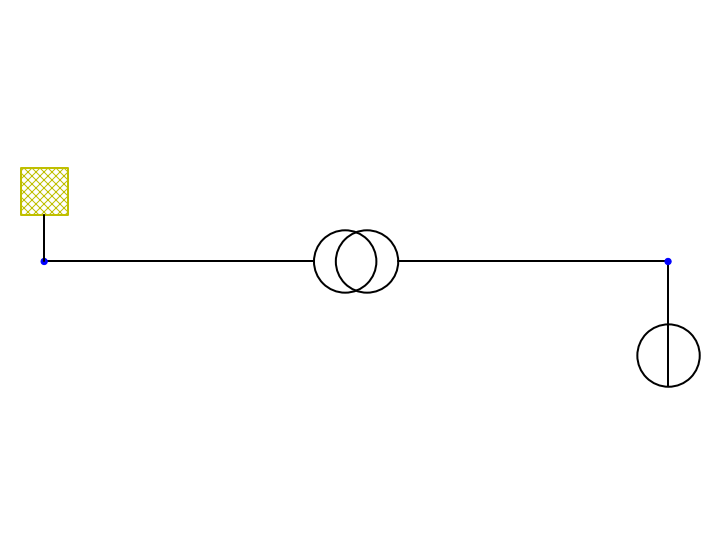

In [4]:
pp.plotting.simple_plot(net, plot_gens=True, gen_size=0.05, trafo_size=10, ext_grid_size=5);

Calculate the zero-sequence impedance of the power station unit transformer related to the HV side (without correction factor $K_T$)

$\underline{Z}_{(0)THV} = (\frac{u_{Rr}}{100 \%} + j \frac{u_{Xr}}{100 \%}) \frac{U_{rTHV}^2}{S_{rT}}$:

In [5]:
vkx0_percent = np.sqrt(np.square(vk0_percent) - np.square(vkr0_percent))
z_0THV = (vkr0_percent / 100 + 1j * vkx0_percent / 100) * (np.square(vn_trafo_hv) / sn_mva)
z_0THV.at[0]

(0.44083333333333335+13.394791807500003j)

Calculate the correction factor for the power system unit with OLTC 

$K_S = \frac{U_{nQ}^2}{U_{rG}^2} \cdot \frac{U_{rTLV}^2}{U_{rTHV}^2} \cdot \frac{c_{max}}{1+|x_d^{''} - x_T| \sqrt{1-cos^2_{\phi rG}}}$:

In [6]:
v_g = net.gen.vn_kv
v_q = net.bus.loc[net.trafo["hv_bus"].values, "vn_kv"].values
ps_cmax = 1.1
x_t = net.trafo["vk_percent"].values / 100
xdss_pu = net.gen.xdss_pu
sin_phi_gen = np.sqrt(np.clip(1 - net.gen.cos_phi.values**2, 0, None))

ks = (v_q**2/v_g**2) * (vn_trafo_lv**2/vn_trafo_hv**2) * ps_cmax / (1 + np.abs(xdss_pu - x_t) * sin_phi_gen)

In [7]:
ks.at[0]

0.9959344011608376

Calculate the corrected zero-sequence impedance for the power system unit with OLTC 

$\underline{Z}_{(0)SK} = K_S \cdot \underline{Z}_{(0)THV} + 3 \cdot \underline{Z}_N$:

In [8]:
zn = 1j * net.trafo.xn_ohm
z_0SK = ks * z_0THV + 3*zn
z_0SK.at[0]

(0.4390410818450693+79.34033395747662j)

Calculate the correction factor for the power system unit without OLTC 

$K_{SO} = \frac{U_{nQ}}{U_{rG} \cdot (1+p_G)} \cdot \frac{U_{rTLV}}{U_{rTHV}} \cdot (1 \pm p_T) \cdot \frac{c_{max}}{1+x_d^{''} \sqrt{1-cos^2_{\phi rG}}}$:

In [9]:
p_g = net.gen.pg_percent / 100
p_t = net.trafo['pt_percent'] / 100
kso = (v_q / (v_g * (1 + p_g))) * (vn_trafo_lv / vn_trafo_hv) * (1 - p_t) * ps_cmax / (1 + xdss_pu * sin_phi_gen)

Calculate the corrected zero-sequence impedance for the power system unit without OLTC 

$\underline{Z}_{(0)SOK} = K_{SO} \cdot \underline{Z}_{(0)THV} + 3 \cdot \underline{Z}_N$:

In [10]:
z_0SOK = kso * z_0THV + 3*zn
z_0SOK.at[0]

(0.3620364715643616+77.00053647635505j)